In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# 68_transformer.ipynb
68_transformer.ipynb
- transformer 학습
- (xgb+lgb+rf) + meta model(log.reg.) 스태킹 모델 학습
- (xgb+lgb+rf+transformer) + meta model(log.reg.) 스태킹 모델 학습 및 성능 검증
 - 이때 transformer는 미리 전체 training 데이터셋에 대해 학습된 상태 그대로 사용됨. <a/></a>
- FE 데이터로 위 3가지 모델 학습
- FE+SMOTE 데이터로 위 3가지 모델 학습


# preprocessing_v1
- shares 너무 높은 것 outlier로 판단해 삭제
- winsorize
- 겹치는 값이 많은 변수 3개 삭제, 'id' 삭제
- is_weekend 추가
- 결측치 채우기
- categorical 변수들 one-hot encoding
- 결과물은 df에 담겨 있음
- winsorize 시각화 부분은 실행 시간이 길어서 임시로 주석 처리했습니다

In [3]:
# CSV 파일 불러오기
df = pd.read_csv('train.csv')
df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,shares,y
0,17335,9.0,409.0,0.501326,1.0,0.587361,23.0,2.0,11.0,0.0,...,-0.1875,-0.1,0.50,0.500,0.00,0.500,Lifestyle,NaN,801.0,0.0
1,21242,10.0,317.0,0.725086,1.0,0.830097,6.0,3.0,NaN,21.0,...,-0.6000,NaN,0.00,0.000,0.50,0.000,Lifestyle,Tuesday,426.0,0.0
2,9448,11.0,447.0,0.584091,1.0,0.730104,NaN,1.0,1.0,1.0,...,-0.5000,-0.1,0.75,0.125,0.25,0.125,World,Friday,2400.0,1.0
3,36797,13.0,143.0,0.638298,NaN,0.787500,3.0,2.0,NaN,0.0,...,0.0000,0.0,1.00,NaN,0.50,0.500,Social Media,NaN,1100.0,0.0
4,29504,17.0,576.0,0.524412,1.0,0.714286,8.0,3.0,NaN,0.0,...,-1.0000,-0.1,0.00,0.000,0.50,0.000,World,Wednesday,1500.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20080 entries, 0 to 20079
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            20080 non-null  int64  
 1   n_tokens_title                18094 non-null  float64
 2   n_tokens_content              18133 non-null  float64
 3   n_unique_tokens               18029 non-null  float64
 4   n_non_stop_words              18103 non-null  float64
 5   n_non_stop_unique_tokens      18051 non-null  float64
 6   num_hrefs                     18040 non-null  float64
 7   num_self_hrefs                18027 non-null  float64
 8   num_imgs                      18053 non-null  float64
 9   num_videos                    17984 non-null  float64
 10  average_token_length          18060 non-null  float64
 11  num_keywords                  18047 non-null  float64
 12  kw_min_min                    18079 non-null  float64
 13  k

In [5]:
df.describe()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,y
count,20080.000000,18094.000000,18133.000000,18029.000000,18103.000000,18051.000000,18040.00000,18027.000000,18053.000000,17984.000000,...,18129.000000,18022.000000,17996.000000,18084.000000,18009.000000,18050.000000,18019.000000,18036.000000,20079.000000,20079.000000
mean,19837.620518,10.384326,544.548006,0.530688,0.969784,0.673145,10.86480,3.307761,4.462305,1.255338,...,0.755363,-0.259961,-0.523741,-0.107415,0.283863,0.068607,0.343026,0.155057,3484.627422,0.494447
std,11462.054124,2.108238,462.048136,0.138912,0.171186,0.155201,11.12579,3.967865,8.052618,4.120357,...,0.248553,0.128353,0.290354,0.095801,0.326501,0.264337,0.188449,0.225428,13171.642756,0.499982
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,22.000000,0.000000
25%,9923.750000,9.000000,246.000000,0.471129,1.000000,0.626628,4.00000,1.000000,1.000000,0.000000,...,0.600000,-0.329167,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,949.000000,0.000000
50%,19906.500000,10.000000,408.000000,0.539877,1.000000,0.691803,8.00000,3.000000,1.000000,0.000000,...,0.800000,-0.253571,-0.500000,-0.100000,0.142857,0.000000,0.500000,0.000000,1400.000000,0.000000
75%,29697.250000,12.000000,717.000000,0.609865,1.000000,0.755020,14.00000,4.000000,4.000000,1.000000,...,1.000000,-0.187500,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,2800.000000,1.000000
max,39644.000000,19.000000,7413.000000,1.000000,1.000000,1.000000,186.00000,116.000000,108.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000,1.000000


## *데이터 전처리*

(0.0, 20000.0)

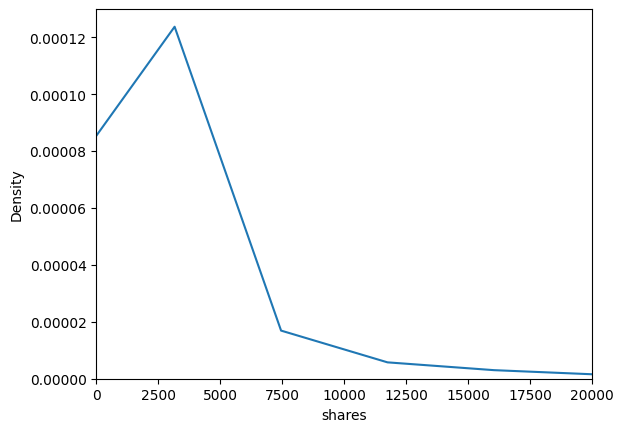

In [6]:
# 공유 수 분포 그래프
sns.kdeplot(df['shares'])
plt.xlim(0, 20000)

In [7]:
# 이상치 제거 비율에 따른 수치 통계

from scipy.stats import skew, kurtosis

quantiles = [1.0, 0.998, 0.995, 0.99, 0.98, 0.975]
summary_list = []

for q in quantiles:
    threshold = df['shares'].quantile(q)
    temp = df[df['shares'] <= threshold]['shares']

    summary = {
        'quantile': q,
        'count': temp.count(),
        'mean': temp.mean(),
        'std': temp.std(),
        'skew': skew(temp),
        'kurtosis': kurtosis(temp),
        'min': temp.min(),
        'max': temp.max()
    }

    summary_list.append(summary)

summary_df = pd.DataFrame(summary_list)
print(summary_df)


   quantile  count         mean           std       skew     kurtosis   min  \
0     1.000  20079  3484.627422  13171.642756  34.463544  1730.344472  22.0   
1     0.998  20038  3086.662042   5802.573953   6.698840    60.903920  22.0   
2     0.995  19979  2898.049752   4628.376680   5.079789    34.305903  22.0   
3     0.990  19878  2700.605494   3691.292658   3.842841    18.306253  22.0   
4     0.980  19678  2469.449944   2886.148951   3.030480    10.519978  22.0   
5     0.975  19582  2389.155142   2654.237815   2.843338     9.089328  22.0   

        max  
0  843300.0  
1   87600.0  
2   53100.0  
3   32500.0  
4   20400.0  
5   17400.0  


quantile = 0.98 에서 mean, std, skew(첨도), kurtosis(왜도)의 급격한 변화가 관찰된다. 따라서 shares가 상위 2%에 해당하는 데이터를 이상치로 간주하고 제거한다.

(0.0, 8500.0)

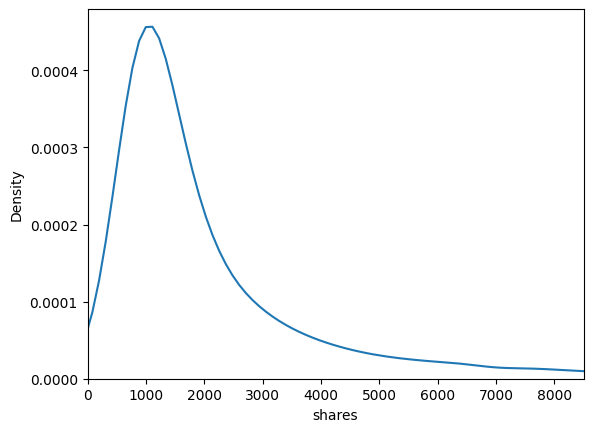

In [8]:
threshold = df['shares'].quantile(0.98)
df = df[df['shares'] <= threshold]

sns.kdeplot(df['shares'])
plt.xlim(0, 8500)

In [9]:
# 가장 많이 등장한 값이 전체에서 차지하는 비율 top 10
top_ratio_dict = {}

for col in df.columns:
    most_common = df[col].value_counts(dropna=False).iloc[0]
    total = len(df)
    ratio = most_common / total
    top_ratio_dict[col] = ratio

top_10 = sorted(top_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:10]

for col, ratio in top_10:
    print(f"{col}: {ratio:.2%}")

kw_max_max: 68.12%
num_videos: 56.46%
kw_min_min: 51.62%
y: 51.59%
abs_title_subjectivity: 46.70%
title_sentiment_polarity: 45.71%
abs_title_sentiment_polarity: 45.63%
num_imgs: 41.54%
title_subjectivity: 40.91%
kw_min_avg: 38.90%


In [10]:
# 중복 값이 많은 변수들을 자세히 살펴보자
df['kw_min_min'].value_counts(dropna=False).head(5)

,count
kw_min_min,
-1.0,10157
4.0,5396
217.0,2122
NaN,1953
0.0,32


In [11]:
df['kw_max_max'].value_counts(dropna=False).head(5)

,count
kw_max_max,
843300.0,13404
NaN,1992
690400.0,1804
617900.0,1017
69100.0,590


In [12]:
df['n_non_stop_words_rounded'] = df['n_non_stop_words'].round(3)  # 소수 셋째 자리까지 반올림
df['n_non_stop_words_rounded'].value_counts(dropna=False)

,count
n_non_stop_words_rounded,
1.0,17208
NaN,1938
0.0,532


In [13]:
# 많은 값들이 같은 값을 가지므로 삭제한다
df.drop(columns=['kw_min_min'], axis=1, inplace=True)
df.drop(columns=['kw_max_max'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words_rounded'], axis=1, inplace=True)

In [14]:
# 'id'는 각 샘플마다 고유한 값을 가진다. 학습에 사용할 값이 아니므로 삭제한다
df.drop(columns=['id'], axis=1, inplace=True)

In [15]:
# # Scatter plot

X = df.drop(columns=['shares', 'y'])
X = X.select_dtypes(include=['number']) # 숫자형만 필터링
y = df['shares']
target = 'shares'

# # 시각화
# plt.figure(figsize=(18, 20))

# for i, feature in enumerate(X.columns):
#     plt.subplot(7, 6, i + 1)
#     plt.tight_layout(pad=1.5)
#     plt.scatter(X[feature], y, alpha=0.3)
#     plt.xlabel(feature)
#     plt.ylabel(target)

# plt.tight_layout()
# plt.show()

In [16]:
# winsorize
from scipy.stats.mstats import winsorize
feature_with_outliers = ["n_tokens_content", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos", "kw_max_min", "kw_avg_min", "kw_max_avg", "kw_avg_avg", "self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess", "global_rate_positive_words", "global_rate_negative_words", "avg_positive_polarity", "min_positive_polarity"]

# Define the percentile thresholds for Winsorization
lower_percentile = 0.0
upper_percentile = 0.0002

# Apply Winsorization to each input variable
for feature in X.columns:
    if feature in feature_with_outliers:
      X[feature] = winsorize(X[feature], limits=(lower_percentile, upper_percentile))


In [17]:
# 요일별 shares의 평균, 최댓값, 최솟값
weekday_stats = df.groupby('weekday')['shares'].agg(
    avg_shares=lambda x: round(x.mean(), 2),
    max_shares='max',
    min_shares='min'
).reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['weekday'] = pd.Categorical(weekday_stats['weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('weekday')
print(weekday_stats)

     weekday  avg_shares  max_shares  min_shares
1     Monday     2378.93     20300.0        43.0
5    Tuesday     2349.26     20400.0        60.0
6  Wednesday     2376.23     20300.0        48.0
4   Thursday     2380.60     20400.0        22.0
0     Friday     2411.85     20400.0        28.0
2   Saturday     3111.34     19800.0        49.0
3     Sunday     3053.10     20000.0       171.0


In [18]:
# 결측치 처리
for col in df.columns:
    if df[col].dtype == 'object': # 범주형 → 최빈값
        df[col] = df[col].fillna(df[col].mode()[0]) # 첫번째 최빈값으로 채우기
    else: # 숫자형 → 중간값
        df[col] = df[col].fillna(df[col].median())

In [19]:
# is_weekend 변수 추가
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 범주형 데이터 One-Hot Encoding
df = pd.get_dummies(df, columns=['data_channel', 'weekday'], drop_first=True)



---



# 모델 학습 전 준비
- train과 validation set 나누기, 정규화, 커스텀 평가 지표 정의, KFold 설정

## *- train, val 나누기, 정규화, 커스텀 평가 지표 정의, KFold 설정*

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19678 entries, 0 to 20078
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                19678 non-null  float64
 1   n_tokens_content              19678 non-null  float64
 2   n_unique_tokens               19678 non-null  float64
 3   n_non_stop_unique_tokens      19678 non-null  float64
 4   num_hrefs                     19678 non-null  float64
 5   num_self_hrefs                19678 non-null  float64
 6   num_imgs                      19678 non-null  float64
 7   num_videos                    19678 non-null  float64
 8   average_token_length          19678 non-null  float64
 9   num_keywords                  19678 non-null  float64
 10  kw_max_min                    19678 non-null  float64
 11  kw_avg_min                    19678 non-null  float64
 12  kw_min_max                    19678 non-null  float64
 13  kw_avg

In [21]:
# X, y 분리
X = df.drop(columns=['shares', 'y'])
y = df['y']

# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 커스텀 평가 지표 정의
def my_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    y_proba = estimator.predict_proba(X)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])

    result = (accuracy + f1 + roc_auc) / 3
    return result

# KFold 설정
random_state = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# 개별 모델 정의, 학습
- transformer
- xgboost, lightGBM, random forest -> stacking_model
 - stacking_model:: (rf+xgb+lgb) + logistic_regression

## *- transformer*

In [22]:
!pip install tweepy==3.10.0

  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.15.0
    Uninstalling tweepy-4.15.0:
      Successfully uninstalled tweepy-4.15.0


In [23]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s e

In [24]:
!pip uninstall -y torch torchvision torchaudio

# CUDA 11.8 버전 기준 GPU 지원 PyTorch 재설치
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/triton-3.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/955.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━

In [25]:
!pip install shapely

In [26]:
!pip install tabular-transformer

In [27]:
import tabular_transformer as ttf
import torch
from torch.utils.data import DataLoader
# import os

# gpu 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() \
    and torch.cuda.is_bf16_supported() else 'float16'
print(device,",", dtype)

cuda , bfloat16


In [58]:
# 범주형과 연속형 변수 명시 (X와 y가 합쳐졌을 때 기준)
categorical_cols = ['y']
numerical_cols = X_train.columns.to_list()

# X_train과 X_val의 bool 열을 int 열로 변환
for col in X_train.columns[X_train.dtypes == bool]:
    X_train[col] = X_train[col].astype(int)
for col in X_val.columns[X_val.dtypes == bool]:
    X_val[col] = X_val[col].astype(int)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ndarray -> DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

# train dataframe, validation dataframe 만들어 저장
train_scaled_df = pd.concat([X_train_scaled_df, y_train], axis=1)
val_scaled_df = pd.concat([X_val_scaled_df, y_val], axis=1)

# df를 .csv 파일로 /content/에 저장하기
train_scaled_df.to_csv("/content/train_scaled_dataset.csv", index=False)
val_scaled_df.to_csv("/content/val_scaled_dataset.csv", index=False)


In [59]:
# file path 설정
train_dataset_path = "/content/train_scaled_dataset.csv"
val_dataset_path = "/content/val_scaled_dataset.csv"

# data reader 생성
train_data_reader = ttf.DataReader(
    file_path=train_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols,
    label='y',
    header=True,
)

val_data_reader = ttf.DataReader(
    file_path=val_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols,
    label='y',
    header=True,
)


In [60]:
# TrainSettings 설정
ts = ttf.TrainSettings(
    wandb_log=False,
    device=device,
    dtype=dtype,
    apply_power_transform=True,
    min_cat_count=0.02,
    dataset_seed=42,
    torch_seed=42
)

# HyperParameters 설정
hp = ttf.HyperParameters(
    dim=64,
    n_layers=2,
    n_heads=2,
    output_hidden_dim=64,
    output_forward_dim=4,
    dropout=0.2,
    weight_decay=0.2,
    beta1=0.9,
    beta2=0.95
)

# Trainer 및 TrainParameters 설정
trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=10000,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=200,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt'
)

In [61]:
# 모델 학습
print("\n" + "=" * 50)
print("transformer 모델 학습 중...")
print("=" * 50)
trainer.train(data_reader=train_data_reader, tp=train_tp, resume=False)

# 모델 저장
# model_path = "transformer_model.pt"
# trainer.save_checkpoint(model_path)
# print(f"모델이 저장되었습니다: {model_path}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
step 5100: train loss 0.3939, val loss 0.7751
5100 | epoch 52.0408 | loss 0.4848 |lr 1.500000e-04 | 390.17ms | mfu  0.09%
5101 | epoch 52.0510 | loss 0.4691 |lr 1.499519e-04 | 24.83ms | mfu  0.09%
5102 | epoch 52.0612 | loss 0.4773 |lr 1.499038e-04 | 24.43ms | mfu  0.09%
5103 | epoch 52.0714 | loss 0.5365 |lr 1.498557e-04 | 24.69ms | mfu  0.10%
5104 | epoch 52.0816 | loss 0.4839 |lr 1.498077e-04 | 24.33ms | mfu  0.10%
5105 | epoch 52.0918 | loss 0.5586 |lr 1.497596e-04 | 24.38ms | mfu  0.10%
5106 | epoch 52.1020 | loss 0.4762 |lr 1.497115e-04 | 24.18ms | mfu  0.10%
5107 | epoch 52.1122 | loss 0.4861 |lr 1.496634e-04 | 24.02ms | mfu  0.10%
5108 | epoch 52.1224 | loss 0.5164 |lr 1.496153e-04 | 25.19ms | mfu  0.10%
5109 | epoch 52.1327 | loss 0.5114 |lr 1.495672e-04 | 24.55ms | mfu  0.10%
5110 | epoch 52.1429 | loss 0.5112 |lr 1.495191e-04 | 24.27ms | mfu  0.10%
5111 | epoch 52.1531 | loss 0.4872 |lr 1.494711e-04 | 24.04ms | mfu  0.10%
5112 | epoch 52.1

In [62]:
model_checkpoint = 'out/train_ckpt.pt'

# 모델 예측
predictor = ttf.Predictor(checkpoint=model_checkpoint)
prediction = predictor.predict(
    data_reader=val_data_reader,
    save_as="val_predictions.csv"
)

# 평가
y_pred = prediction['prediction'].astype(float).astype(int)
y_prob = prediction['probability']

# 실제 값
# y_val = val_data_reader.get_labels()  # Validation 데이터의 실제 값

# 평가 지표 계산
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='binary')
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

# 결과 출력
print("\n[RESULT] Transformer Model Performance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")


load checkpoint from out/train_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 49.53it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425
save prediction output to file: out/val_predictions.csv

[RESULT] Transformer Model Performance:
Accuracy      : 0.642530
F1 Score      : 0.631772
AUC           : 0.699436
Average Score : 0.657913


In [63]:
# 예측용 wrapper 클래스
from sklearn.base import BaseEstimator, ClassifierMixin

class TransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, predictor, val_data_reader):
        self.predictor = predictor
        self.val_data_reader = val_data_reader

    def fit(self, X, y=None):
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self  # 이미 학습 완료

    def predict(self, X):
        predictions = self.predictor.predict(data_reader=self.val_data_reader, save_as=None)
        return predictions['prediction'].astype(float).astype(int).to_numpy()

    def predict_proba(self, X):
        predictions = self.predictor.predict(data_reader=self.val_data_reader, save_as=None)
        probs = predictions['probability']
        # 클래스 0,1 확률 반환 형식 맞추기
        return np.vstack([1 - probs, probs]).T

# TransformerWrapper 인스턴스 생성 (val_data_reader는 유효한 데이터 로더여야 함)
transformer_wrapper = TransformerWrapper(predictor, val_data_reader)


In [64]:
transformer_wrapper.predict(X_val_scaled)

load checkpoint from out/train_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 50.47it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425


array([1, 1, 0, ..., 1, 1, 0])

## *- xgboost, lightGBM, random forest -> stacking_model*

In [65]:
# xgb boost
xgb_model = XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=200,
    subsample=0.8, colsample_bytree=1.0, random_state=42, use_label_encoder=False, eval_metric='logloss'
)

# light GBM
lgbm_model = LGBMClassifier(
    learning_rate=0.05019492506075167, max_depth=6, n_estimators=379,
    num_leaves=141, feature_fraction=0.8488251044495548, random_state=42
)

# random forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, max_features='log2', random_state=42
)

# 메타 모델
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# 스태킹 모델
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False,
    stack_method='predict_proba'
)


In [66]:
# 학습
print("\n" + "=" * 50)
print("stacking 모델 학습 중...")
print("=" * 50)
stacking_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = stacking_model.predict(X_val_scaled)
y_prob = stacking_model.predict_proba(X_val_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\n[RESULT] Final Model Performance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

# 저장 (선택)
import joblib
joblib.dump(stacking_model, 'best_stacking_model.pkl')
print("\n[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.")


stacking 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548

[RESULT] Final Model Performance:
Accuracy      : 0.658791
F1 Score      : 0.639463
AUC           : 0.716996
Average Score : 0.671750

[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.


# Stacking
- Stacking:: (rf+xgb+lgb+transformer) + logistic_regression

## *Stacking*

In [67]:
final_stacking_model = StackingClassifier(
    estimators=[
        ('transformer', transformer_wrapper),  # Transformer 포함
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'
)

# 학습
final_stacking_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = final_stacking_model.predict(X_val_scaled)
y_prob = final_stacking_model.predict_proba(X_val_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\nPerformance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


load checkpoint from out/train_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 32.42it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548
load checkpoint from out/train_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 32.40it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425
[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Performance:
Accuracy      : 0.659299
F1 Score      : 0.640193
AUC           : 0.717045
Average Score : 0.672179


# FE


In [28]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 25.5 MB/s eta 0:00:00



평일과 주말의 공유수 차이 분석
주말 여부에 따른 공유 수 통계:
                   mean  median           std  count
is_weekend                                          
0           3355.256293  1400.0  12583.496513  19544
1           4229.035015  2000.0  14024.317905   2656
t-검정 결과: t=-3.0485, p=0.00231822
유의미한 차이 있음: 평일과 주말의 공유 수는 통계적으로 유의미한 차이가 있습니다.


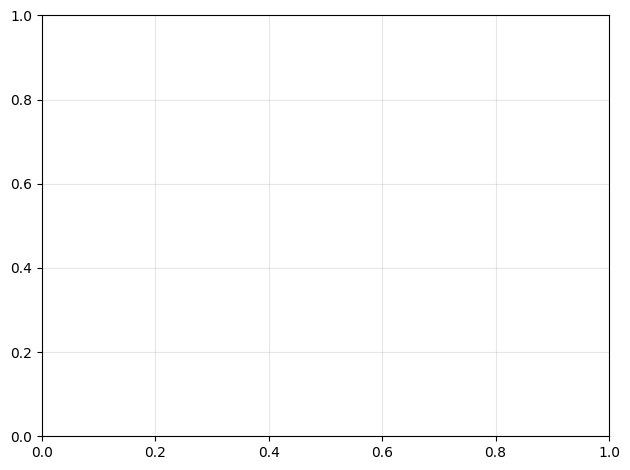

In [29]:
# 추가 파인튜닝을 위한 코드
from scipy import stats
import optuna

# 0. 평일과 주말의 공유 수 차이 확인 (EDA)
print("\n" + "=" * 50)
print("평일과 주말의 공유수 차이 분석")
print("=" * 50)

# 원본 데이터셋으로 평일/주말 비교 (df는 전처리 전 원본 데이터셋)
original_df = pd.read_csv('train.csv')  # 원본 데이터셋 로드

# 주말 플래그 생성
original_df['is_weekend'] = original_df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 평일/주말 그룹별 통계
weekday_stats = original_df.groupby('is_weekend')['shares'].agg(['mean', 'median', 'std', 'count'])
print("주말 여부에 따른 공유 수 통계:")
print(weekday_stats)

# t-검정으로 차이의 유의성 확인
weekday_shares = original_df[original_df['is_weekend'] == 0]['shares']
weekend_shares = original_df[original_df['is_weekend'] == 1]['shares']
t_stat, p_value = stats.ttest_ind(weekday_shares, weekend_shares, equal_var=False)

print(f"t-검정 결과: t={t_stat:.4f}, p={p_value:.8f}")
if p_value < 0.05:
    print("유의미한 차이 있음: 평일과 주말의 공유 수는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("유의미한 차이 없음: 평일과 주말의 공유 수는 통계적으로 유의미한 차이가 없습니다.")


    height = bar.get_height()
    plt.annotate(f'{height:.6f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 테스트 데이터에도 Feature Engineering 적용

In [30]:
# 1. Feature Engineering
print("\n" + "=" * 50)
print("Feature Engineering 적용")
print("=" * 50)

# 원본 X_train과 X_val 저장 (비교를 위해)
X_train_original = X_train.copy()
X_val_original = X_val.copy()

# 1.1 키워드 관련 변수 조합
print("키워드 관련 변수 조합 추가...")
for df in [X_train, X_val]:
    # 비율 변수 추가
    df['kw_avg_avg_to_max_avg'] = df['kw_avg_avg'] / (df['kw_max_avg'] + 1e-5)  # 0 나누기 방지
    df['kw_min_avg_to_max_avg'] = df['kw_min_avg'] / (df['kw_max_avg'] + 1e-5)

    # 차이 변수 추가
    df['kw_max_min_diff'] = df['kw_max_min'] - df['kw_avg_min']
    df['kw_avg_max_diff'] = df['kw_avg_max'] - df['kw_min_max']

# 1.2 정서 분석 변수 조합
print("정서 분석 변수 조합 추가...")
for df in [X_train, X_val]:
    # 긍정/부정 비율
    df['pos_to_neg_polarity'] = (df['avg_positive_polarity'] + 1) / (-df['avg_negative_polarity'] + 1)

    # 감정 강도 관련 변수
    df['polarity_range'] = df['max_positive_polarity'] - df['min_negative_polarity']
    df['polarity_diff'] = df['avg_positive_polarity'] - (-df['avg_negative_polarity'])

    # 제목과 내용의 감정 일치도
    df['title_content_polarity_match'] = abs(df['title_sentiment_polarity'] - df['global_sentiment_polarity'])

# 1.3 시간 관련 특성 세분화
print("시간 관련 특성 세분화...")
# 이미 is_weekend 변수가 있으므로, 요일별 특성 추가
# 요일별 평균 공유 수를 특성으로 추가 (target 정보 유출 방지를 위해 평균 공유 수 대신 가중치 사용)
weekday_weight = {
    'weekday_Monday': 0.95,
    'weekday_Tuesday': 0.93,
    'weekday_Wednesday': 0.93,
    'weekday_Thursday': 0.94,
    'weekday_Friday': 0.97,
    'weekday_Saturday': 1.25,
    'weekday_Sunday': 1.22
}

for df in [X_train, X_val]:
    df['weekday_weight'] = 0
    for day, weight in weekday_weight.items():
        if day in df.columns:
            df['weekday_weight'] += df[day] * weight

# 1.4 기타 특성 추가
print("기타 특성 추가...")
for df in [X_train, X_val]:
    # LDA 주제 조합
    df['lda_max_topic'] = df[['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']].max(axis=1)
    df['lda_diversity'] = df[['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']].std(axis=1)

    # 콘텐츠 길이와 다양성
    df['token_length_ratio'] = df['n_tokens_content'] / (df['n_unique_tokens'] + 1e-5)

# 정규화
print("특성 정규화...")
X_train_fe = X_train.copy()
X_val_fe = X_val.copy()

scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_val_fe_scaled = scaler_fe.transform(X_val_fe)



Feature Engineering 적용
키워드 관련 변수 조합 추가...
정서 분석 변수 조합 추가...
시간 관련 특성 세분화...
기타 특성 추가...
특성 정규화...


## transformer

In [31]:
# 범주형과 연속형 변수 명시 (X와 y가 합쳐졌을 때 기준)
categorical_cols = ['y']
numerical_cols_fe = X_train_fe.columns.to_list()

# ndarray -> DataFrame으로 변환
X_train_fe_scaled_df = pd.DataFrame(X_train_fe_scaled, columns=X_train_fe.columns, index=X_train_fe.index)
X_val_fe_scaled_df = pd.DataFrame(X_val_fe_scaled, columns=X_val_fe.columns, index=X_val_fe.index)

# train dataframe, validation dataframe 만들어 저장
train_fe_scaled_df = pd.concat([X_train_fe_scaled_df, y_train], axis=1)
val_fe_scaled_df = pd.concat([X_val_fe_scaled_df, y_val], axis=1)

# file path 설정
train_fe_dataset_path = "/content/train_fe_scaled_dataset.csv"
val_fe_dataset_path = "/content/val_fe_scaled_dataset.csv"

# df를 .csv 파일로 /content/에 저장하기
train_fe_scaled_df.to_csv(train_fe_dataset_path, index=False)
val_fe_scaled_df.to_csv(val_fe_dataset_path, index=False)


In [32]:

# data reader 생성
train_fe_data_reader = ttf.DataReader(
    file_path=train_fe_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols_fe,
    label='y',
    header=True,
)

val_fe_data_reader = ttf.DataReader(
    file_path=val_fe_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols_fe,
    label='y',
    header=True,
)


In [33]:
# TrainSettings 설정
ts_fe = ttf.TrainSettings(
    wandb_log=False,
    device=device,
    dtype=dtype,
    apply_power_transform=True,
    min_cat_count=0.02,
    dataset_seed=42,
    torch_seed=42
)

In [34]:
# HyperParameters 설정
hp_fe = ttf.HyperParameters(
    dim=64,
    n_layers=2,
    n_heads=2,
    output_hidden_dim=64,
    output_forward_dim=4,
    dropout=0.2,
    weight_decay=0.2,
    beta1=0.9,
    beta2=0.95
)

# Trainer 및 TrainParameters 설정
trainer_fe = ttf.Trainer(hp=hp_fe, ts=ts_fe)

train_tp_fe = ttf.TrainParameters(
    max_iters=10000,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=200,
    lr_scheduler='cosine',
    output_checkpoint='train_fe_ckpt.pt'
)

# 모델 학습
print("\n" + "=" * 50)
print("transformer 모델 학습 중...")
print("=" * 50)
trainer_fe.train(data_reader=train_fe_data_reader, tp=train_tp_fe, resume=False)

model_fe_checkpoint = 'out/train_fe_ckpt.pt'

# 모델 예측
predictor_fe = ttf.Predictor(checkpoint=model_fe_checkpoint)
prediction_fe = predictor_fe.predict(
    data_reader=val_fe_data_reader,
    save_as="val_fe_predictions.csv"
)

# 평가
y_pred_fe = prediction_fe['prediction'].astype(float).astype(int)
y_prob_fe = prediction_fe['probability']

# 평가 지표 계산
acc_fe = accuracy_score(y_val, y_pred_fe)
f1_fe = f1_score(y_val, y_pred_fe, average='binary')
auc_fe = roc_auc_score(y_val, y_prob_fe)
average_score_fe = np.mean([acc_fe, f1_fe, auc_fe])

# 결과 출력
print("\n[RESULT] Transformer Model Performance:")
print(f"Accuracy      : {acc_fe:.6f}")
print(f"F1 Score      : {f1_fe:.6f}")
print(f"AUC           : {auc_fe:.6f}")
print(f"Average Score : {average_score_fe:.6f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5102 | epoch 52.0612 | loss 0.4773 |lr 1.499038e-04 | 27.37ms | mfu  0.09%
5103 | epoch 52.0714 | loss 0.5365 |lr 1.498557e-04 | 27.37ms | mfu  0.09%
5104 | epoch 52.0816 | loss 0.4839 |lr 1.498077e-04 | 27.33ms | mfu  0.09%
5105 | epoch 52.0918 | loss 0.5586 |lr 1.497596e-04 | 27.11ms | mfu  0.09%
5106 | epoch 52.1020 | loss 0.4762 |lr 1.497115e-04 | 26.96ms | mfu  0.09%
5107 | epoch 52.1122 | loss 0.4861 |lr 1.496634e-04 | 29.15ms | mfu  0.09%
5108 | epoch 52.1224 | loss 0.5164 |lr 1.496153e-04 | 27.43ms | mfu  0.09%
5109 | epoch 52.1327 | loss 0.5114 |lr 1.495672e-04 | 26.67ms | mfu  0.09%
5110 | epoch 52.1429 | loss 0.5112 |lr 1.495191e-04 | 26.67ms | mfu  0.09%
5111 | epoch 52.1531 | loss 0.4872 |lr 1.494711e-04 | 26.87ms | mfu  0.09%
5112 | epoch 52.1633 | loss 0.5140 |lr 1.494230e-04 | 26.94ms | mfu  0.09%
5113 | epoch 52.1735 | loss 0.5404 |lr 1.493749e-04 | 27.14ms | mfu  0.09%
5114 | epoch 52.1837 | loss 0.5390 |lr 1.493268e-04 | 27.52ms | 

100%|██████████| 4/4 [00:00<00:00, 46.54it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425
save prediction output to file: out/val_fe_predictions.csv

[RESULT] Transformer Model Performance:
Accuracy      : 0.642530
F1 Score      : 0.631772
AUC           : 0.699436
Average Score : 0.657913


In [49]:
# 예측용 wrapper 클래스
from sklearn.base import BaseEstimator, ClassifierMixin

class TransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, predictor, val_data_reader):
        self.predictor = predictor
        self.val_data_reader = val_data_reader

    def fit(self, X, y=None):
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self  # 이미 학습 완료

    def predict(self, X):
        predictions = self.predictor.predict(data_reader=self.val_data_reader, save_as=None)
        return predictions['prediction'].astype(float).astype(int).to_numpy()

    def predict_proba(self, X):
        predictions = self.predictor.predict(data_reader=self.val_data_reader, save_as=None)
        probs = predictions['probability']
        # 클래스 0,1 확률 반환 형식 맞추기
        return np.vstack([1 - probs, probs]).T

# TransformerWrapper 인스턴스 생성 (val_data_reader는 유효한 데이터 로더여야 함)
transformer_wrapper_fe = TransformerWrapper(predictor_fe, val_fe_data_reader)


## xgb,lgb,rf -> stacking_model

In [35]:
# xgb boost
xgb_model = XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=200,
    subsample=0.8, colsample_bytree=1.0, random_state=42, use_label_encoder=False, eval_metric='logloss'
)

# light GBM
lgbm_model = LGBMClassifier(
    learning_rate=0.05019492506075167, max_depth=6, n_estimators=379,
    num_leaves=141, feature_fraction=0.8488251044495548, random_state=42
)

# random forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, max_features='log2', random_state=42
)

# 메타 모델
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# 스태킹 모델
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False,
    stack_method='predict_proba'
)


In [36]:
# 학습
print("\n" + "=" * 50)
print("stacking 모델 학습 중...")
print("=" * 50)
stacking_model.fit(X_train_fe_scaled, y_train)

# 예측 및 평가
y_pred = stacking_model.predict(X_val_fe_scaled)
y_prob = stacking_model.predict_proba(X_val_fe_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\n[RESULT] Final Model Performance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

# 저장 (선택)
import joblib
joblib.dump(stacking_model, 'best_stacking_model.pkl')
print("\n[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.")


stacking 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548

[RESULT] Final Model Performance:
Accuracy      : 0.658791
F1 Score      : 0.639463
AUC           : 0.716996
Average Score : 0.671750

[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.


## xgb+lgb+rf+tranformer stacking

In [41]:
final_stacking_model = StackingClassifier(
    estimators=[
        ('transformer', transformer_wrapper_fe),  # Transformer 포함
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'
)

# 학습
final_stacking_model.fit(X_train_fe_scaled, y_train)

# 예측 및 평가
y_pred = final_stacking_model.predict(X_val_fe_scaled)
y_prob = final_stacking_model.predict_proba(X_val_fe_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\nPerformance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


load checkpoint from out/train_fe_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 32.28it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548
load checkpoint from out/train_fe_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 42.01it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425
[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Performance:
Accuracy      : 0.659299
F1 Score      : 0.640193
AUC           : 0.717045
Average Score : 0.672179


# FE + SMOTE

In [42]:
# 2. 불균형 처리 (SMOTE)
print("\n" + "=" * 50)
print("SMOTE로 클래스 불균형 처리")
print("=" * 50)

# 클래스 분포 확인
print("원본 클래스 분포:")
print(pd.Series(y_train).value_counts(normalize=True))

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_fe_smote, y_train_smote = smote.fit_resample(X_train_fe_scaled, y_train)

print("SMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


SMOTE로 클래스 불균형 처리
원본 클래스 분포:
y
0.0    0.513531
1.0    0.486469
Name: proportion, dtype: float64
SMOTE 적용 후 클래스 분포:
y
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [48]:
X_train_fe_smote.shape
# X_train_fe_scaled.shape

(16168, 65)

## tranformer

In [50]:
# 범주형과 연속형 변수 명시 (X와 y가 합쳐졌을 때 기준)
# categorical_cols = ['y']
# numerical_cols_fe = X_train_fe.columns.to_list()

# ndarray -> DataFrame으로 변환
X_train_fe_smote_df = pd.DataFrame(X_train_fe_smote, columns=X_train_fe.columns, index=None)
# X_val_fe_scaled_df = pd.DataFrame(X_val_fe_scaled, columns=X_val_fe.columns, index=X_val_fe.index)

# train dataframe, validation dataframe 만들어 저장
train_fe_smote_df = pd.concat([X_train_fe_smote_df, y_train_smote], axis=1)
# val_fe_scaled_df = pd.concat([X_val_fe_scaled_df, y_val], axis=1)

# file path 설정
train_fe_smote_dataset_path = "/content/train_fe_smote_dataset.csv"
# val_fe_dataset_path = "/content/val_fe_scaled_dataset.csv"

# df를 .csv 파일로 /content/에 저장하기
train_fe_smote_df.to_csv(train_fe_smote_dataset_path, index=False)
# val_fe_scaled_df.to_csv(val_fe_dataset_path, index=False)


In [51]:

# data reader 생성
train_fe_smote_data_reader = ttf.DataReader(
    file_path=train_fe_smote_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols_fe,
    label='y',
    header=True,
)

# val_fe_data_reader = ttf.DataReader(
#     file_path=val_fe_dataset_path,
#     ensure_categorical_cols=categorical_cols,
#     ensure_numerical_cols=numerical_cols_fe,
#     label='y',
#     header=True,
# )


In [52]:
# TrainSettings 설정
ts_fe_smote = ttf.TrainSettings(
    wandb_log=False,
    device=device,
    dtype=dtype,
    apply_power_transform=True,
    min_cat_count=0.02,
    dataset_seed=42,
    torch_seed=42
)

In [53]:
# HyperParameters 설정
hp_fe_smote = ttf.HyperParameters(
    dim=64,
    n_layers=2,
    n_heads=2,
    output_hidden_dim=64,
    output_forward_dim=4,
    dropout=0.2,
    weight_decay=0.2,
    beta1=0.9,
    beta2=0.95
)

# Trainer 및 TrainParameters 설정
trainer_fe_smote = ttf.Trainer(hp=hp_fe_smote, ts=ts_fe_smote)

train_tp_fe_smote = ttf.TrainParameters(
    max_iters=10000,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=200,
    lr_scheduler='cosine',
    output_checkpoint='train_fe_smote_ckpt.pt'
)

# 모델 학습
print("\n" + "=" * 50)
print("transformer 모델 학습 중...")
print("=" * 50)
trainer_fe_smote.train(data_reader=train_fe_smote_data_reader,
                       tp=train_tp_fe_smote,
                       resume=False)

model_fe_checkpoint = 'out/train_fe_smote_ckpt.pt'

# 모델 예측
predictor_fe_smote = ttf.Predictor(checkpoint=model_fe_checkpoint)
prediction_fe_smote = predictor_fe.predict(
    data_reader=val_fe_data_reader,
    save_as="val_fe_predictions.csv"
)

# 평가
y_pred = prediction_fe_smote['prediction'].astype(float).astype(int)
y_prob = prediction_fe_smote['probability']

# 평가 지표 계산
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='binary')
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

# 결과 출력
print("\n[RESULT] Transformer Model Performance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5102 | epoch 50.5149 | loss 0.4882 |lr 1.499038e-04 | 24.83ms | mfu  0.08%
5103 | epoch 50.5248 | loss 0.4770 |lr 1.498557e-04 | 24.75ms | mfu  0.08%
5104 | epoch 50.5347 | loss 0.5401 |lr 1.498077e-04 | 24.65ms | mfu  0.08%
5105 | epoch 50.5446 | loss 0.4512 |lr 1.497596e-04 | 24.61ms | mfu  0.09%
5106 | epoch 50.5545 | loss 0.5188 |lr 1.497115e-04 | 25.35ms | mfu  0.09%
5107 | epoch 50.5644 | loss 0.5058 |lr 1.496634e-04 | 24.79ms | mfu  0.09%
5108 | epoch 50.5743 | loss 0.5116 |lr 1.496153e-04 | 29.73ms | mfu  0.09%
5109 | epoch 50.5842 | loss 0.4875 |lr 1.495672e-04 | 31.32ms | mfu  0.09%
5110 | epoch 50.5941 | loss 0.4868 |lr 1.495191e-04 | 32.19ms | mfu  0.09%
5111 | epoch 50.6040 | loss 0.4818 |lr 1.494711e-04 | 28.79ms | mfu  0.09%
5112 | epoch 50.6139 | loss 0.5277 |lr 1.494230e-04 | 28.39ms | mfu  0.09%
5113 | epoch 50.6238 | loss 0.4771 |lr 1.493749e-04 | 28.16ms | mfu  0.09%
5114 | epoch 50.6337 | loss 0.5379 |lr 1.493268e-04 | 28.77ms | 

100%|██████████| 4/4 [00:00<00:00, 48.35it/s]

binary cross entropy loss: 0.633548
auc score: 0.699436
f1 macro score: 0.642225
samples: 3936, accuracy: 0.6425
save prediction output to file: out/val_fe_predictions.csv

[RESULT] Transformer Model Performance:
Accuracy      : 0.642530
F1 Score      : 0.631772
AUC           : 0.699436
Average Score : 0.657913


In [54]:
# TransformerWrapper 인스턴스 생성 (val_data_reader는 유효한 데이터 로더여야 함)
transformer_wrapper_fe_smote = TransformerWrapper(predictor_fe_smote, val_fe_data_reader)

## xgb, lgb, rf -->stacking_model

In [55]:
# xgb boost
xgb_model = XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=200,
    subsample=0.8, colsample_bytree=1.0, random_state=42, use_label_encoder=False, eval_metric='logloss'
)

# light GBM
lgbm_model = LGBMClassifier(
    learning_rate=0.05019492506075167, max_depth=6, n_estimators=379,
    num_leaves=141, feature_fraction=0.8488251044495548, random_state=42
)

# random forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, max_features='log2', random_state=42
)

# 메타 모델
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# 스태킹 모델
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False,
    stack_method='predict_proba'
)


In [56]:
# 학습
print("\n" + "=" * 50)
print("stacking 모델 학습 중...")
print("=" * 50)
stacking_model.fit(X_train_fe_smote, y_train_smote)

# 예측 및 평가
y_pred = stacking_model.predict(X_val_fe_scaled)
y_prob = stacking_model.predict_proba(X_val_fe_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\n[RESULT] Final Model Performance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

# 저장 (선택)
import joblib
joblib.dump(stacking_model, 'best_stacking_model.pkl')
print("\n[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.")


stacking 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548

[RESULT] Final Model Performance:
Accuracy      : 0.660569
F1 Score      : 0.648051
AUC           : 0.717456
Average Score : 0.675359

[INFO] 모델이 'best_stacking_model.pkl'로 저장되었습니다.


## xgb+lgb+rf+tranformer stacking

In [57]:
final_stacking_model = StackingClassifier(
    estimators=[
        ('transformer', transformer_wrapper_fe_smote),  # Transformer 포함
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'
)

# 학습
final_stacking_model.fit(X_train_fe_smote, y_train_smote)

# 예측 및 평가
y_pred = final_stacking_model.predict(X_val_fe_scaled)
y_prob = final_stacking_model.predict_proba(X_val_fe_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
average_score = np.mean([acc, f1, auc])

print("\nPerformance:")
print(f"Accuracy      : {acc:.6f}")
print(f"F1 Score      : {f1:.6f}")
print(f"AUC           : {auc:.6f}")
print(f"Average Score : {average_score:.6f}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


load checkpoint from out/train_fe_smote_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 32.01it/s]

binary cross entropy loss: 0.640789
auc score: 0.694260



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


f1 macro score: 0.639138
samples: 3936, accuracy: 0.6392
[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548
load checkpoint from out/train_fe_smote_ckpt.pt
start reading file, it may take a while..
read file completed.


100%|██████████| 4/4 [00:00<00:00, 41.81it/s]

binary cross entropy loss: 0.640789
auc score: 0.694260
f1 macro score: 0.639138
samples: 3936, accuracy: 0.6392
[LightGBM] [Warning] feature_fraction is set=0.8488251044495548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8488251044495548



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Performance:
Accuracy      : 0.659299
F1 Score      : 0.646640
AUC           : 0.717628
Average Score : 0.674522
